In [1]:
library(statsr)
library(dplyr)
library(ggplot2)
library(BAS)
library(pander)

Loading required package: BayesFactor

Loading required package: coda

Loading required package: Matrix

Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "numericVector" of class "Mnumeric"; definition not updated”
************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
load("../input/finalcapstone/ames_train.Rdata")

## Part 1 - Exploratory Data Analysis (EDA)

When you first get your data, it's very tempting to immediately begin fitting models and assessing how they perform.  However, before you begin modeling, it's absolutely essential to explore the structure of the data and the relationships between the variables in the data set.

Do a detailed EDA of the ames_train data set, to learn about the structure of the data and the relationships between the variables in the data set (refer to Introduction to Probability and Data, Week 2, for a reminder about EDA if needed). Your EDA should involve creating and reviewing many plots/graphs and considering the patterns and relationships you see. 

After you have explored completely, submit the three graphs/plots that you found most informative during your EDA process, and briefly explain what you learned from each (why you found each informative).

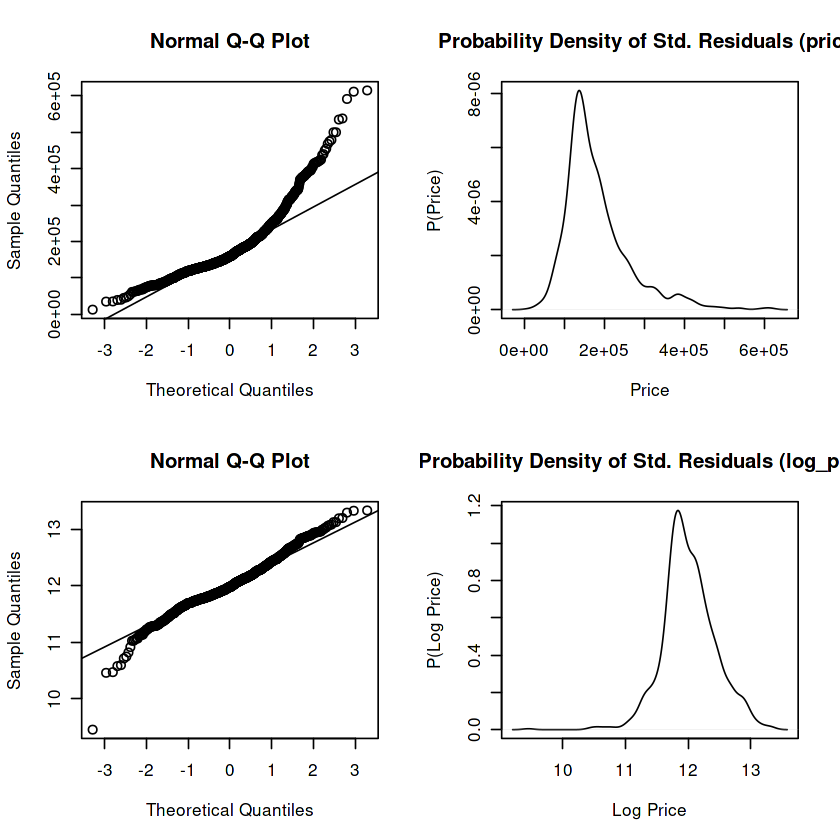

In [3]:
par(mfrow=c(2,2))
qqnorm(ames_train$price, lty = 2)
qqline(ames_train$price)
plot(density(ames_train$price), main="Probability Density of Std. Residuals (price)", 
    xlab="Price", ylab="P(Price)")
qqnorm(log(ames_train$price), lty = 2)
qqline(log(ames_train$price))
plot(density(log(ames_train$price)), main="Probability Density of Std. Residuals (log_price)", 
    xlab="Log Price", ylab="P(Log Price)")

First graph: It's not linear, the anomalies are the houses whose prices are much more expensive than the majority of the others.
Third graph: It's more linear after being log-transformed. We also perform log transformation for the remaining variables.

For example, let's examine the relationship between house price and house area. You will see that the relationship between price and area will become linear from non-linear after log transformation.

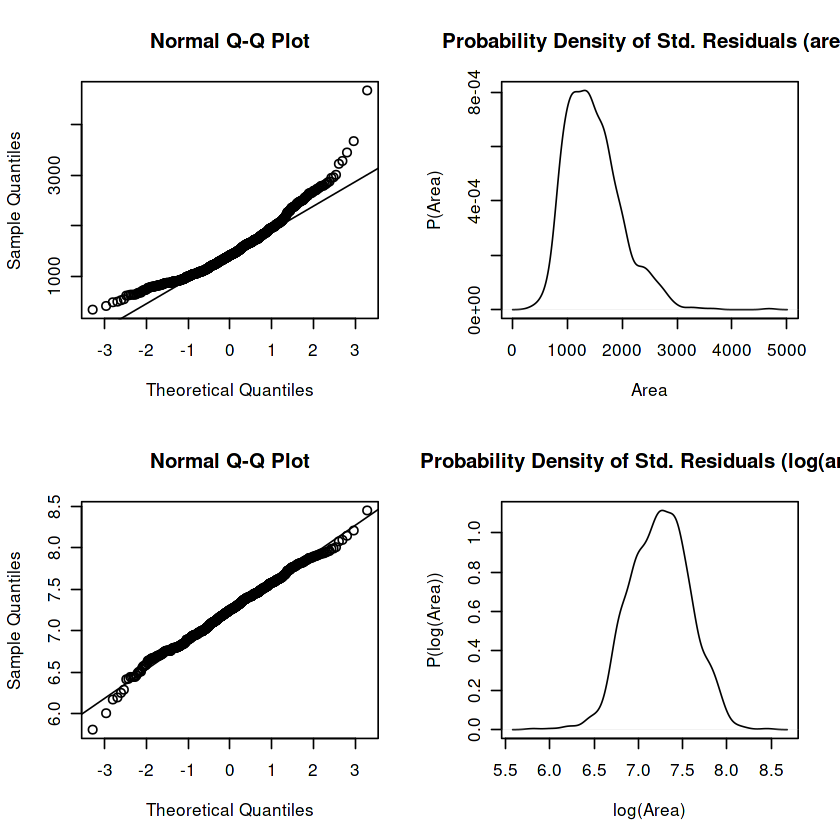

In [4]:
par(mfrow=c(2,2))
qqnorm(ames_train$area, lty = 2)
qqline(ames_train$area)
plot(density(ames_train$area), main="Probability Density of Std. Residuals (area)", 
    xlab="Area", ylab="P(Area)")
qqnorm(log(ames_train$area), lty = 2)
qqline(log(ames_train$area))
plot(density(log(ames_train$area)), main="Probability Density of Std. Residuals (log(area))", 
    xlab="log(Area)", ylab="P(log(Area))")

Another important feature is the house quality

In [5]:
ames_train %>% 
    group_by(Overall.Qual) %>% 
    summarize(Q1 = quantile(price, 0.25), MEAN = mean(price), MEDIAN = median(price),Q3 = quantile(price, 0.75), IQR = IQR(price), STDEV = sd(price)) %>%
    mutate(SKEW = ifelse(MEAN > MEDIAN, "RIGHT", "LEFT")) %>%
    pandoc.table



| Overall.Qual |   Q1   |  MEAN  | MEDIAN |   Q3   |  IQR   | STDEV  | SKEW  |
|:------------:|:------:|:------:|:------:|:------:|:------:|:------:|:-----:|
|      1       | 39300  | 39300  | 39300  | 39300  |   0    |   NA   | LEFT  |
|      2       | 42578  | 51076  | 50750  | 64951  | 22373  | 21376  | RIGHT |
|      3       | 67000  | 81233  | 79000  | 92900  | 25900  | 16074  | RIGHT |
|      4       | 80000  | 106044 | 101000 | 125125 | 45125  | 37116  | RIGHT |
|      5       | 120500 | 132812 | 132000 | 145000 | 24500  | 24000  | RIGHT |
|      6       | 140000 | 163069 | 159000 | 183000 | 43000  | 40373  | RIGHT |
|      7       | 180375 | 205505 | 197500 | 228625 | 48250  | 43162  | RIGHT |
|      8       | 222725 | 272502 | 261414 | 315000 | 92275  | 68499  | RIGHT |
|      9       | 327925 | 382016 | 379250 | 413125 | 85200  | 81243  | RIGHT |
|      10      | 386250 | 428341 | 450000 | 500067 | 113817 | 126364 | LEFT  |



Joining, by = "Overall.Qual"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


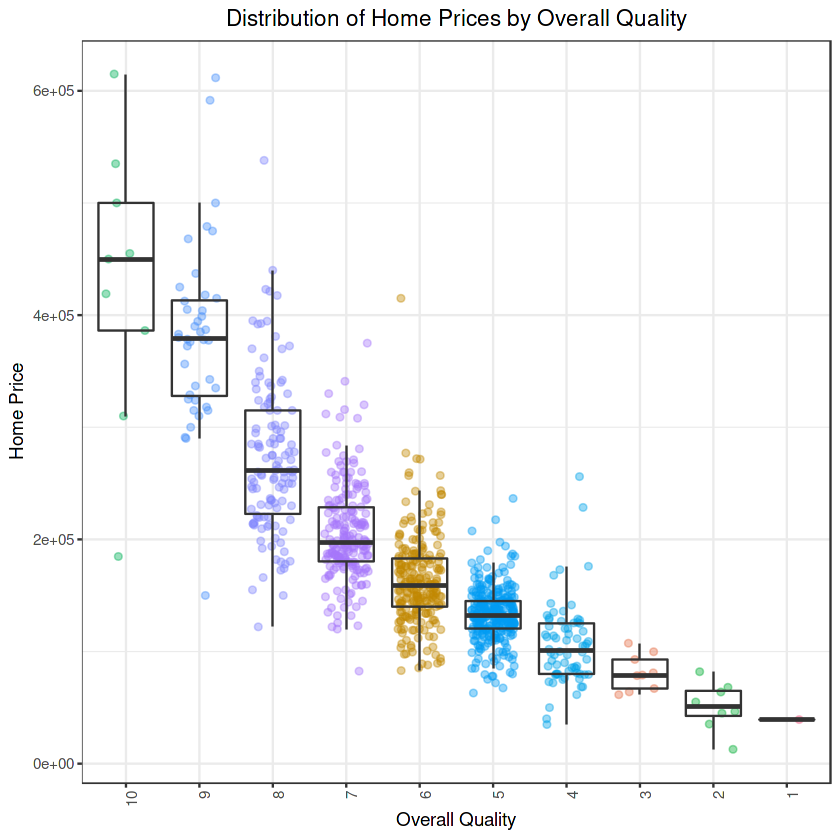

In [6]:
median_data = ames_train %>% 
    group_by(Overall.Qual) %>% 
    summarize(med_price = median(price), IQR_price = IQR(price))
cc = sample(colorspace::rainbow_hcl(27, c = 100, l=60,start = 0, end = 300), 10)
ames_train %>%
    left_join(median_data) %>%
    mutate(Overall.Qual = reorder(Overall.Qual, -med_price)) %>%
    ggplot(aes(x=Overall.Qual, y = price)) +
    geom_jitter(aes(color=Overall.Qual),alpha= 0.4, height = 0, width = 0.3) +
    geom_boxplot(fill=NA, outlier.shape=NA) +
    scale_color_manual(values = cc) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 90, hjust = 1)) +
    guides(fill=FALSE, color=FALSE) +
    labs(title = "Distribution of Home Prices by Overall Quality", 
                 y = "Home Price", 
                 x = "Overall Quality")

Most houses score between 4 and 8 which means the model might give more accurate predictions on houses whose quality's scores are from 4 to 8 (and less accurate predictions on houses whose quality's scores are not from 4 to 8)

## Part 2 - Development and assessment of an initial model, following a semi-guided process of analysis

### Section 2.1 An Initial Model
In building a model, it is often useful to start by creating a simple, intuitive initial model based on the results of the exploratory data analysis. (Note: The goal at this stage is **not** to identify the "best" possible model but rather to choose a reasonable and understandable starting point. Later you will expand and revise this model to create your final model.

Based on your EDA, select *at most* 10 predictor variables from “ames_train” and create a linear model for `price` (or a transformed version of price) using those variables. Provide the *R code* and the *summary output table* for your model, a *brief justification* for the variables you have chosen, and a *brief discussion* of the model results in context (focused on the variables that appear to be important predictors and how they relate to sales price).


In [7]:
fit0 = lm(log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + log(area) + Kitchen.Qual + X1st.Flr.SF + Total.Bsmt.SF + Year.Built + Year.Remod.Add, ames_train)
summary(fit0)


Call:
lm(formula = log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + 
    log(area) + Kitchen.Qual + X1st.Flr.SF + Total.Bsmt.SF + 
    Year.Built + Year.Remod.Add, data = ames_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.74193 -0.06680  0.00742  0.08588  0.52033 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.089e-01  1.067e+00   0.571 0.568372    
Overall.Qual         7.977e-02  6.980e-03  11.429  < 2e-16 ***
NeighborhoodBlueste -3.986e-02  1.042e-01  -0.382 0.702204    
NeighborhoodBrDale  -1.967e-01  7.223e-02  -2.723 0.006591 ** 
NeighborhoodBrkSide  7.372e-02  6.170e-02   1.195 0.232403    
NeighborhoodClearCr  2.241e-01  6.840e-02   3.276 0.001090 ** 
NeighborhoodCollgCr  6.549e-02  5.068e-02   1.292 0.196615    
NeighborhoodCrawfor  2.285e-01  6.060e-02   3.770 0.000174 ***
NeighborhoodEdwards  2.470e-03  5.533e-02   0.045 0.964406    
NeighborhoodGilbert  5.299e-02  5.392e-02   0.983 0.325957  

The above predictors are the lowest within-sample RMSE variables.

### Section 2.2 Model Selection

Now either using `BAS` another stepwise selection procedure choose the "best" model you can, using your initial model as your starting point. Try at least two different model selection methods and compare their results. Do they both arrive at the same model or do they disagree? What do you think this means?

In [8]:
library(MASS)
print("The AIC step fit process:")
fit_AIC = step(fit0)
print("The BIC step fit process:")
fit_BIC = step(fit0, k=log(nrow(ames_train)))


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




[1] "The AIC step fit process:"
Start:  AIC=-3667.13
log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + log(area) + 
    Kitchen.Qual + X1st.Flr.SF + Total.Bsmt.SF + Year.Built + 
    Year.Remod.Add

                 Df Sum of Sq    RSS     AIC
- X1st.Flr.SF     1    0.0004 23.474 -3669.1
<none>                        23.474 -3667.1
- Exter.Qual      3    0.3316 23.805 -3659.1
- Kitchen.Qual    4    0.4931 23.967 -3654.4
- Year.Built      1    0.5647 24.038 -3645.4
- Year.Remod.Add  1    0.7187 24.192 -3639.0
- Total.Bsmt.SF   1    1.0087 24.482 -3627.1
- Overall.Qual    1    3.1972 26.671 -3541.6
- Neighborhood   26    5.0104 28.484 -3525.9
- log(area)       1    6.9726 30.446 -3409.3

Step:  AIC=-3669.11
log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + log(area) + 
    Kitchen.Qual + Total.Bsmt.SF + Year.Built + Year.Remod.Add

                 Df Sum of Sq    RSS     AIC
<none>                        23.474 -3669.1
- Exter.Qual      3    0.3336 23.808 -3661.0
- Kitchen.Q

Warning message in bas.lm(log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + :
“dropping  1 rows due to missing data”


[1] "Results from the BAS fit:"


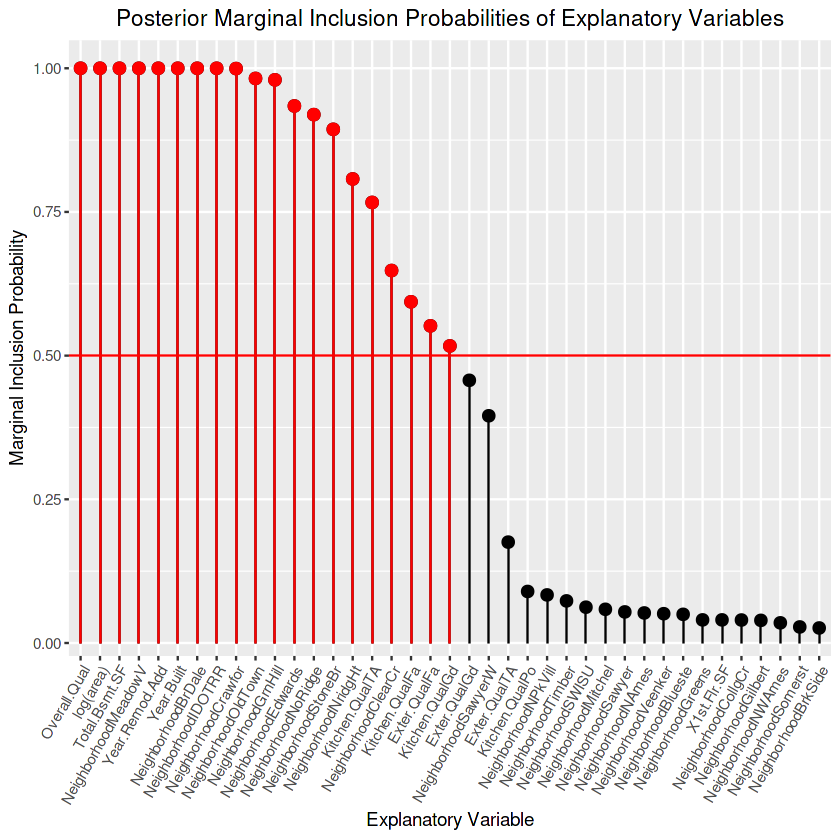

In [9]:
ames0.bas =  bas.lm(log(price) ~ Overall.Qual + Neighborhood + Exter.Qual + log(area) + Kitchen.Qual + X1st.Flr.SF + Total.Bsmt.SF + Year.Built + Year.Remod.Add, 
                   data=ames_train,
                  initprobs = "eplogp",
                   prior="BIC",
                   modelprior=uniform()) 
coefs <- coef(ames0.bas, estimator = "BMA")
# find posterior probabilities 
coefs_bas <- data.frame(parameter = coefs$namesx, post_mean = coefs$postmean, post_SD = coefs$postsd, post_pne0 = coefs$probne0) %>% arrange(post_pne0) %>% filter(parameter != "Intercept")
coefs_bas$parameter <- factor(coefs_bas$parameter, levels = coefs_bas$parameter[order(coefs_bas$post_pne0, decreasing = TRUE)])
high_pne0 <- data.frame(parameter = coefs_bas$parameter, post_pne0 = coefs_bas$post_pne0) %>% filter(post_pne0 > 0.5)
# Plot the Data
print("Results from the BAS fit:")
ggplot(coefs_bas, aes(x = parameter, y = post_pne0)) + 
    geom_pointrange(aes(ymax = post_pne0), ymin = 0) +
    geom_pointrange(data=high_pne0, aes(x = parameter, y = post_pne0, ymax = post_pne0), ymin = 0, color = "red") +
    geom_hline(yintercept = 0.5, color = "red") +
    labs(title = "Posterior Marginal Inclusion Probabilities of Explanatory Variables",x="Explanatory Variable",y = "Marginal Inclusion Probability") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1), plot.title = element_text(hjust = 0.5))

The above graph demonstrates the result of the BAS fit

### Section 2.3 Initial Model Residuals
One way to assess the performance of a model is to examine the model's residuals. In the space below, create a residual plot for your preferred model from above and use it to assess whether your model appears to fit the data well. Comment on any interesting structure in the residual plot (trend, outliers, etc.) and briefly discuss potential implications it may have for your model and inference / prediction you might produce.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



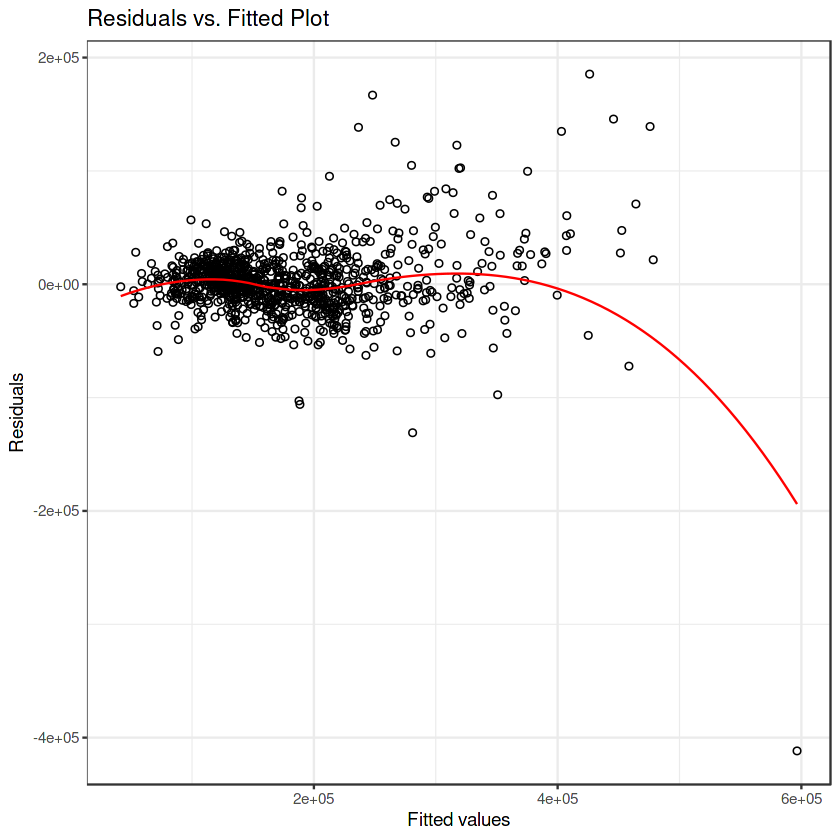

In [10]:
pred_train <- predict(ames0.bas,ames_train,estimator = "BMA")
resid_train <- na.omit(ames_train$price - exp(pred_train$fit))
plot_dat <- data.frame(fitted = na.omit(exp(pred_train$fit)), resid = resid_train)
ggplot(plot_dat, aes(x = fitted, y = resid)) + geom_point(pch=21, fill=NA) + 
    geom_smooth(color= "red", se = FALSE, lwd = 0.5) + 
    labs(title = "Residuals vs. Fitted Plot", y = "Residuals", x = "Fitted values") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme_bw()

The residual versus fitted plot suggests that the model gives consistent bias and variance for the lower price houses, but the variance of the residuals increases as the predicted price increases. 

### Section 2.4 Initial Model RMSE

You can calculate it directly based on the model output. Be specific about the units of your RMSE (depending on whether you transformed your response variable). The value you report will be more meaningful if it is in the original units (dollars).

In [11]:
rmse_train = sqrt(mean(resid_train^2))
rmse_train = round(rmse_train, 2)
print(paste0("The within-sample root-mean-squared error is ", rmse_train, " dollars"))

[1] "The within-sample root-mean-squared error is 30507.42 dollars"


### Section 2.5 Overfitting 

The process of building a model generally involves starting with an initial model (as you have done above), identifying its shortcomings, and adapting the model accordingly. This process may be repeated several times until the model fits the data reasonably well. However, the model may do well on training data but perform poorly out-of-sample (meaning, on a dataset other than the original training data) because the model is overly-tuned to specifically fit the training data. This is called “overfitting.” To determine whether overfitting is occurring on a model, compare the performance of a model on both in-sample and out-of-sample data sets. To look at performance of your initial model on out-of-sample data, you will use the data set `ames_test`.


In [12]:
load("../input/test-val-set/ames_test.Rdata")

From here, I have to say that doing this project on my local device, Rstudio and Kaggle notebook cloud does not work for me. Rstudio got stuck when I tried to go further part 2.1. kaggle only brought me to part 2.5 then it ran out of memory. However, I believe that if you copy and paste my code to your device, it would work. Please kindlt understand this.

In [13]:
#ames_test = ames_test %>% filter(Neighborhood != "Landmrk")
#pred_test = predict(ames0.bas,newdata=ames_test,estimator = "BMA")
#resid_test = ames_test$price - exp(pred_test$fit)
#rmse_test = sqrt(mean(resid_test^2))
#rmse_test = round(rmse_test, 2)
#print(paste0("The out-of-sample RMSE is ", rmse_test ," dollars."))

## Part 3 Development of a Final Model

Now that you have developed an initial model to use as a baseline, create a final model with *at most* 20 variables to predict housing prices in Ames, IA, selecting from the full array of variables in the dataset and using any of the tools that we introduced in this specialization.  

Carefully document the process that you used to come up with your final model, so that you can answer the questions below.

### Section 3.1 Final Model

Provide the summary table for your model.

In [14]:
#ames_train = ames_train[-310,]
#ames.bas =  bas.lm(log(price) ~ Overall.Qual+Neighborhood+Exter.Qual+log(area)+Kitchen.Qual+X1st.Flr.SF+Total.Bsmt.SF+Year.Built+Year.Remod.Add+Garage.Cars+BsmtFin.SF.1+log(area):Overall.Qual:X1st.Flr.SF+Overall.Qual:X1st.Flr.SF+BsmtFin.SF.1:Overall.Qual:X1st.Flr.SF+log(area):Overall.Qual:Year.Built+log(area):Overall.Qual+Garage.Cars:Overall.Qual+log(area):Year.Built+log(area):Garage.Cars, 
#data=ames_train,initprobs = "eplogp", prior="BIC", modelprior=uniform()) 

### Section 3.2 Transformation

Did you decide to transform any variables?  Why or why not? Explain in a few sentences.

Yes, one example is the relationship between price and area will became linear from non-linear after log transformation in part 1.

### Section 3.3 Variable Interaction

Did you decide to include any variable interactions? Why or why not? Explain in a few sentences.

I decided not to include any variable interactions as the features are moderately correlated.

### Section 3.4 Variable Selection

What method did you use to select the variables you included? Why did you select the method you used? Explain in a few sentences.

The BAS package using Bayes Model Averaging (BMA) was used to manage variable selection. The BMA process reduces or eliminates the coefficients that have a low posterior probability of inclusion in the model. This allows more information to be preserved by not totally eliminating some variables, but also limits the effects of overfitting by reducing the magnitude of the coefficients for low posterior probability variables.


### Section 3.5 Model Testing

How did testing the model on out-of-sample data affect whether or how you changed your model? Explain in a few sentences.

In all cases of testing the model on the out-of-sample data, the testing RMSE was lower than the training RMSE. Thus, overfitting was not a key concern in the analysis as the model actually performed better on the held-out data.

The out-of-sample data was used to confirm the removal of the outlier house, row 310, as removing this outlier before training the model reduced the test error compared to leaving it in.

## Part 4 Final Model Assessment

### Section 4.1 Final Model Residual

For your final model, create and briefly interpret an informative plot of the residuals.

In [15]:
#pred_train <- predict(ames.bas,ames_train,estimator = "BMA")
#resid_train <- na.omit(ames_train$price - exp(pred_train$fit))
#plot_dat <- data.frame(fitted = na.omit(exp(pred_train$fit)), resid = resid_train)
#ggplot(plot_dat, aes(x = fitted, y = resid)) + 
    #geom_point(pch=21, fill=NA) +
    #geom_smooth(color= "red", se = FALSE, lwd = 0.5) + 
    #labs(title = "Residuals vs. Fitted Plot", y = "Residuals", x = "Fitted values") +
    #theme(plot.title = element_text(hjust = 0.5)) +
    #theme_bw()

In [16]:
#rmse_train = sqrt(mean(resid_train^2))
#rmse_train = round(rmse_train, 2)
#print(paste0("The within-sample RMSE is", rmse_train," dollars.")

#ames_test = ames_test %>% filter(Neighborhood != "Landmrk")
#pred_test = predict(ames.bas,newdata=ames_test,estimator = "BMA")

#resid_test = ames_test$price - exp(pred_test$fit)
#rmse_test = sqrt(mean(resid_test^2))
#rmse_test = round(rmse_test, 2)
#print(paste0("The out-of-sample RMSE is", rmse_test," dollars.")

### Section 4.3 Final Model Evaluation

What are some strengths and weaknesses of your model?

* Strength: The model gives relatively accurate and acceptablepredictions.
* Weakness: The model is less consistent for predicting larger house prices.

### Section 4.4 Final Model Validation

Testing your final model on a separate, validation data set is a great way to determine how your model will perform in real-life practice. 

You will use the “ames_validation” dataset to do some additional assessment of your final model. Discuss your findings, be sure to mention:
* What is the RMSE of your final model when applied to the validation data?  
* How does this value compare to that of the training data and/or testing data?
* What percentage of the 95% predictive confidence (or credible) intervals contain the true price of the house in the validation data set?  
* From this result, does your final model properly reflect uncertainty?

In [17]:
#load("ames_validation.Rdata")

In [18]:
#pred_valid_se = predict(ames.bas,newdata=ames_validation,estimator = "BMA", se.fit=TRUE)
#resid_valid = ames_validation$price - exp(pred_valid_se$fit)
#rmse_valid = sqrt(mean(resid_valid^2))
#print(paste0("The out-of-sample validation RMSE is",rmse_valid ,"dollars.")

## Part 5 Conclusion

Provide a brief summary of your results, and a brief discussion of what you have learned about the data and your model. 


Linear regression models can consistently predict home prices for the majority of homes in this market. However, the model is less consistent when predicting the price of more expensive homes in such conditions.

If the goal is to predict typical houses price, outliers can be removed.